# LeJepa trainer

> This module implements LeJepa training procedure.

In [ ]:
#| default_exp trainers.trainer_lejepa

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *
from torchvision.utils import save_image
import torch
import os
from torch import nn
import pandas as pd

In [ ]:
#| hide
import torch
from torchvision.transforms import v2
train_tf = v2.Compose(
    [
        # Keep the size at 42 to match your model architecture
        v2.ToPILImage(),
        v2.RandomResizedCrop(42, scale=(0.8, 1.0)), 
        v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        v2.RandomGrayscale(p=0.2),
        # Reduced kernel size for smaller image resolution
        # v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.1),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        # Normalizes to [-1, 1] to match Tanh output
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [ ]:
#| hide
from mawm.data.loaders import RolloutObservationDataset

# | hide
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40

dataset = RolloutObservationDataset(
    agent='agent_0',
    root='../datasets/marl_grid_data/',
    transform=train_tf,
    buffer_size=10,
    train=True
)
dataset.load_next_buffer()

Loading file buffer ...:   0%|          | 0/10 

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
#| hide
dataset[10][0].shape

torch.Size([3, 42, 42])

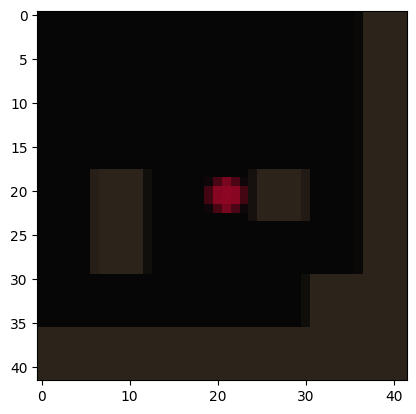

In [ ]:
#| hide
import matplotlib.pyplot as plt
def denormalize(tensor):
    # If using mean=0.5, std=0.5:
    return tensor * 0.5 + 0.5
    
    # If using ImageNet stats (your current code):
    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    # return tensor * std + mean

# Visualization
img_tensor = dataset[0][0]
img_to_show = denormalize(img_tensor)

# Clip just in case of tiny floating point errors to satisfy plt.imshow
# img_to_show = torch.clamp(img_to_show, 0, 1)

plt.imshow(img_to_show.permute(1, 2, 0).numpy())
plt.show()

In [ ]:
#| hide
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, V=1):
        self.V = V
        self.ds = dataset
        self.aug = train_tf
        self.test = v2.Compose(
            [
                v2.ToPILImage(),
                v2.Resize(42),
                v2.CenterCrop(42),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

    def __getitem__(self, i):
        item = self.ds[i][0]
        img = item# item["image"].convert("RGB")
        transform = self.aug if self.V > 1 else self.test
        return torch.stack([transform(img) for _ in range(self.V)])

    def __len__(self):
        return len(self.ds)

In [ ]:
#| hide
jepa_ds = HFDataset(V = 2)

In [ ]:
#| hide
views = jepa_ds[0]

In [ ]:
#| hide
views[0].shape, views[1].shape

(torch.Size([3, 42, 42]), torch.Size([3, 42, 42]))

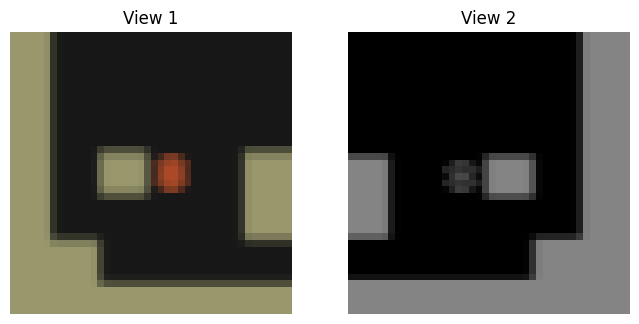

In [ ]:
#| hide
# plot the two views side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(denormalize(views[0]).permute(1, 2, 0).numpy())
axs[0].set_title("View 1")
axs[0].axis('off')
axs[1].imshow(denormalize(views[1]).permute(1, 2, 0).numpy())
axs[1].set_title("View 2")
axs[1].axis('off')
plt.show()

In [ ]:
#| hide
bs = 2  # Example batch size
K = 5   # Example number of centers
g_embed = torch.randn(10, 128)  # Example global embeddings
a_embed = g_embed.detach().clone()

a_embed = a_embed.view(-1, bs, K)
centers = g_embed.view(-1, bs, K).mean(0)
print(centers.shape, a_embed.shape )


torch.Size([2, 5]) torch.Size([128, 2, 5])


In [ ]:
#| hide
sim = (centers - a_embed ).square().mean()

In [ ]:
#| hide
sim

tensor(1.0178)

## Lejepa Trainer

In [ ]:
#| export
from mawm.trainers.trainer import Trainer
from mawm.models.utils import save_checkpoint
from mawm.losses.custom_loss import SIGReg
class LejepaTrainer(Trainer):
    def __init__(self, cfg, model, train_loader, val_loader=None, 
                 criterion=None, optimizer=None, device=None,
                 earlystopping=None, scheduler=None, writer= None):
        
        super().__init__(cfg, model, train_loader, val_loader, criterion, optimizer, device)
        self.earlystopping = earlystopping
        self.scheduler = scheduler
        self.writer = writer
        self.sigreg = SIGReg().to(self.device)
        self.lambda_ = self.cfg.lambda_

        self.lejepa_dir = os.path.join(self.cfg.log_dir, 'lejepa_marlrid')
        if not os.path.exists(self.lejepa_dir):
            os.mkdir(self.lejepa_dir)
            os.mkdir(os.path.join(self.lejepa_dir, 'samples'))

    

In [ ]:
#| export
@patch
def train_epoch(self: LejepaTrainer, epoch):
    self.model.train()
    
    
    train_loss = 0
    actual_len = 0

    while True:
        try:
            self.train_loader.dataset.load_next_buffer()
        except:
            break
        
        for batch_idx, data in enumerate(self.train_loader):

            obs, dones, agent_id = data
            mask = ~dones.bool()     # keep only where done is False

            if mask.sum() == 0:
                continue  # entire batch is terminals

            obs = obs[mask]          # filter observations
            obs = obs.to(self.device)

            self.optimizer.zero_grad()

            proj = self.model(obs)
            inv_loss = (proj.mean(0) - proj).square().mean()
            sigreg_loss = self.sigreg(proj)
            
            loss = (1- self.lambda_) * inv_loss + self.lambda_ * sigreg_loss
            train_loss += loss.item()
            
            loss.backward()
            self.optimizer.step()
            actual_len += obs.size(0)         
            

            if batch_idx % 20 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(obs), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader),
                    loss.item() / len(obs)))
                
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / actual_len))

    return train_loss / actual_len
       

In [ ]:
#| export
@patch
def eval_epoch(self: LejepaTrainer):
    self.model.eval()

    test_loss = 0
    actual_len = 0

    with torch.no_grad():
        while True:
            try:
                self.val_loader.dataset.load_next_buffer()
            except:
                break

            for batch_idx, data in enumerate(self.val_loader):
                obs, dones, agent_id = data
                mask = ~dones.bool()     # keep only where done is False

                if mask.sum() == 0:
                    continue  # entire batch is terminals

                obs = obs[mask]          # filter observations
                obs = obs.to(self.device)

                proj = self.model(obs)
                inv_loss = (proj.mean(0) - proj).square().mean()
                sigreg_loss = self.sigreg(proj)
                
                loss = (1 - self.lambda_) * inv_loss + self.lambda_ * sigreg_loss
                test_loss += loss.item()
                actual_len += obs.size(0)


    test_loss /= actual_len
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


In [ ]:
#| export
import wandb

@patch
def fit(self: LejepaTrainer):
    cur_best = None
    lst_dfs = []

    for epoch in range(1, self.cfg.epochs + 1):
        train_loss = self.train_epoch(epoch)
        test_loss = self.eval_epoch()

        # checkpointing
        best_filename = os.path.join(self.lejepa_dir, 'best.pth')
        filename = os.path.join(self.lejepa_dir, 'checkpoint.pth')

        is_best = not cur_best or test_loss < cur_best
        if is_best:
            cur_best = test_loss

        state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'test_loss': test_loss,
            'optimizer': self.optimizer.state_dict(),
        }
        save_checkpoint(state= state, is_best= is_best, filename= filename, best_filename= best_filename)

        to_log = {
            "train_loss": train_loss, 
            "test_loss": test_loss,
        }

        self.writer.write(to_log)
        df = pd.DataFrame.from_records([{"epoch": epoch ,"train_loss": train_loss, "test_loss":test_loss}], index= "epoch")
        lst_dfs.append(df)

        self.train_loader.dataset.reset_buffer()
        self.val_loader.dataset.reset_buffer()

    df_res = pd.concat(lst_dfs)
    df_reset = df_res.reset_index()
    self.writer.write({'Train-Val Loss Table': wandb.Table(dataframe= df_reset)})

    self.writer.finish()
    return df_reset

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()